<a href="https://colab.research.google.com/github/Arya-Jagish/Python_ClassWork/blob/main/CNN_Project_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing necessary libraries

In [3]:
import os
from io import BytesIO
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, UnidentifiedImageError

### Define functions for data exploration and preprocessing

In [4]:
def get_classes(dataset_dir):
    """
    Get the list of class names from the dataset directory.

    Args:
        dataset_dir (str): Path to the dataset directory.

    Returns:
        list: List of class names.
    """
    classes = os.listdir(dataset_dir)
    return classes


def analyze_dataset(dataset_dir, classes):
    """
    Analyze the dataset by printing the number of images per class and unique image shapes.

    Args:
        dataset_dir (str): Path to the dataset directory.
        classes (list): List of class names.
    """
    image_shapes = set()
    images_per_class = {}

    for class_name in classes:
        class_dir = os.path.join(dataset_dir, class_name)
        image_files = os.listdir(class_dir)
        images_per_class[class_name] = len(image_files)
        for image_file in image_files:
            image_path = os.path.join(class_dir, image_file)
            try:
                image = Image.open(image_path)
                image_shapes.add(image.size + (len(image.getbands()),))
            except Exception as e:
                print(f"Error processing image: {image_path}, {e}")

    print("Number of Images per Class:")
    for class_name, count in images_per_class.items():
        print(f"{class_name}: {count}")

    print("\nUnique Image Shapes:")
    for shape in image_shapes:
        print(shape)

In [5]:
def preprocess_image(image):
    # Resize the image to the target size
    image = tf.image.resize(image, target_size)

    # If the image has an alpha channel, drop it
    if image.shape[2] == 4:
        image = image[:, :, :3]

    return image

def create_data_generator(data_dir, target_size, batch_size, validation_split=0.2, augmentation=False, **kwargs):
    """
    Create data generators for training and validation sets.

    Args:
        data_dir (str): Path to the dataset directory.
        target_size (tuple): Tuple specifying the target size of the input images.
        batch_size (int): Number of samples per batch.
        validation_split (float): Fraction of the data to use for validation.
        augmentation (bool): Whether to apply data augmentation.
        **kwargs: Additional arguments to pass to the ImageDataGenerator.

    Returns:
        tuple: (train_generator, validation_generator) - Data generators for training and validation sets.
    """
    if augmentation:
        train_datagen = ImageDataGenerator(
            rescale=1.0 / 255,
            shear_range=0.2,
            zoom_range=0.2,
            rotation_range=30,
            horizontal_flip=True,
            vertical_flip=True,
            brightness_range=(0.85, 1.15),
            validation_split=validation_split,
            preprocessing_function=preprocess_image,
            **kwargs
        )
    else:
        train_datagen = ImageDataGenerator(
            rescale=1.0 / 255,
            validation_split=validation_split,
            preprocessing_function=preprocess_image,
            **kwargs
        )

    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False,
    )

    return train_generator, validation_generator


def display_random_images_from_generator(data_generator, classes, num_images=8):
    images, labels = next(data_generator)
    class_indices = {v: k for k, v in classes.items()}  # Reverse the class indices dictionary
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16/1.5, 8/1.5))

    for i in range(num_images):
        row = i // 4
        col = i % 4
        image = images[i]
        label = labels[i]
        class_index = label.argmax()
        class_name = class_indices[class_index]

        axs[row, col].imshow(image)
        axs[row, col].axis('off')
        axs[row, col].set_title(class_name)

    plt.tight_layout()
    plt.show()

#### Image Preprocessing and Data Generators
- The preprocess_image function resizes images to a standard size and drops any alpha channel (transparency information) if it exists.

- The create_data_generator function creates an ImageDataGenerator which scales image pixel values, applies data augmentation (if enabled), and creates two sets of data: training data and validation data. This function allows you to load images in batches, which is necessary for training deep learning models when the entire dataset cannot fit into memory.

- The display_random_images_from_generator function displays a set of images from a generator. This is helpful for visualizing the data and transformations applied.

### Dataset exploration and preprocessing

In [19]:
dataset_dir = "/content/data"
target_size = (256, 256)
classes = get_classes(dataset_dir)
print("Classes found in the dataset:", classes, "\n")
analyze_dataset(dataset_dir, classes)


Classes found in the dataset: ['green_area', 'desert', '.ipynb_checkpoints', 'water', 'cloudy'] 

Number of Images per Class:
green_area: 1500
desert: 1131
.ipynb_checkpoints: 0
water: 1500
cloudy: 1500

Unique Image Shapes:
(256, 256, 4)
(64, 64, 3)
(256, 256, 3)


In [20]:
train_generator, validation_generator = create_data_generator(dataset_dir, target_size=target_size,
                                                             batch_size=32, validation_split=0.2, augmentation=True)

Found 4505 images belonging to 5 classes.
Found 1126 images belonging to 5 classes.


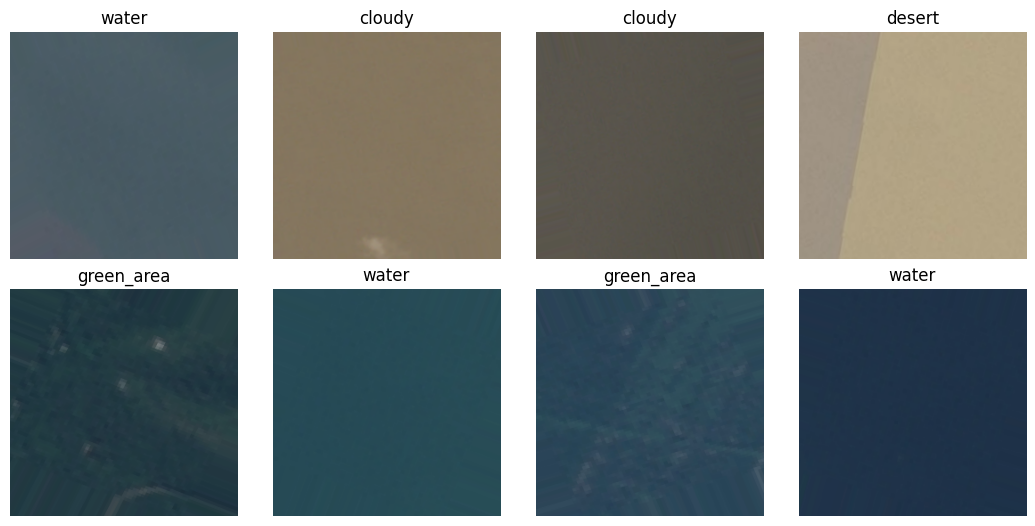

In [21]:
classes = train_generator.class_indices
display_random_images_from_generator(train_generator, classes, num_images=8)

### Building the model

In [22]:
def train_model(train_generator, validation_generator, target_size, num_classes, model_name,
                epochs=30, batch_size=32, patience=3, learning_rate=0.001):

    model = create_model(target_size + (3,), num_classes)
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'], )
    model.summary()

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(model_name + '.h5', save_best_only=True, save_weights_only=True)

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_generator,
        callbacks=[early_stopping, model_checkpoint]
    )

    # Evaluate the model on the validation set
    evaluation = model.evaluate(validation_generator)

    # Save the model
    model.save(model_name + '.h5')

    # Print message when early stopping is triggered
    if early_stopping.stopped_epoch > 0:
        print('Early stopping triggered at epoch', early_stopping.stopped_epoch + 1)

    return history, evaluation


def create_model(input_shape, num_classes):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.15))

    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.30))

    model.add(layers.Flatten())

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.50))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [23]:
# Train the model
history, evaluation = train_model(
    train_generator,
    validation_generator,
    target_size=target_size,
    num_classes=train_generator.num_classes,
    model_name='best_custom_model',
    epochs=20,
    batch_size=32,
    patience=3,
    learning_rate=0.0001
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Early stopping triggered at epoch 20


#### Model Architecture
##### The model architecture is a simple Convolutional Neural Network (CNN). The layers are as follows:

- Conv2D: These are convolution layers that are designed to deal with image data. Each layer will apply filters to the previous layer's output and produce a convolved feature map.
- MaxPooling2D: These are pooling layers that will reduce the dimensionality of the feature maps, summarizing the presence of features in the previous layer's output.
- Dropout: These layers randomly set a fraction of input units to 0 at each update during training, which helps prevent overfitting.
- Flatten: This layer flattens the inputs, converting a multidimensional tensor into a one-dimensional tensor (i.e., a vector).
- Dense: These are fully connected layers where each neuron in a layer is connected to every neuron in the previous layer.
- The final Dense layer has 4 neurons, indicating that the model is designed to classify inputs into one of four classes.

### Saving the model for further use, plot and evaluate metrics

In [24]:
def plot_training_history(history):
    """
    Plot the training and validation loss, and training and validation accuracy.

    Args:
        history (tf.keras.callbacks.History): Training history.
    """
    num_epochs = len(history.history['loss'])

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    fig.suptitle('Training History')

    axs[0].plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
    axs[0].plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
    axs[1].plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

#### Model Evaluation
- The evaluate_model function loads a trained model from a saved file and evaluates it using the validation generator. It calculates overall metrics (accuracy, precision, recall, F1-score) and class-specific metrics. These metrics provide a detailed view of model performance.

In [25]:
def evaluate_model(saved_model_path, validation_generator):
    # Load the saved model
    loaded_model = tf.keras.models.load_model(saved_model_path)

    # Evaluate the model on the test set
    test_loss, test_accuracy = loaded_model.evaluate(validation_generator)
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)

    # Perform thorough evaluation
    y_true = validation_generator.classes
    y_pred = loaded_model.predict(validation_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate overall metrics
    accuracy = metrics.accuracy_score(y_true, y_pred_classes)
    precision = metrics.precision_score(y_true, y_pred_classes, average='weighted')
    recall = metrics.recall_score(y_true, y_pred_classes, average='weighted')
    f1_score = metrics.f1_score(y_true, y_pred_classes, average='weighted')

    print('Overall Metrics:')
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-Score:', f1_score)

    # Calculate metrics per class
    class_metrics = metrics.classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys())
    print('\nMetrics per Class:')
    print(class_metrics)

In [29]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model_path, data_generator):
    # Load the saved model
    model = tf.keras.models.load_model(model_path)

    # Generate predictions on the validation dataset
    data_generator.reset()  # Reset the generator to the beginning
    y_true = data_generator.classes
    y_pred = model.predict(data_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate and print a classification report
    classification_rep = classification_report(y_true, y_pred_classes)
    print("Classification Report:")
    print(classification_rep)

    # Create and print a confusion matrix
    confusion = confusion_matrix(y_true, y_pred_classes)
    print("Confusion Matrix:")
    print(confusion)


In [30]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot training loss and validation loss over epochs
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training accuracy and validation accuracy over epochs
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


36/36 [==============================] - 51s 1s/step
Classification Report:
              precision    recall  f1-score   support

           1       0.96      0.90      0.93       300
           2       0.89      0.97      0.93       226
           3       0.79      0.94      0.86       300
           4       0.92      0.74      0.82       300

    accuracy                           0.88      1126
   macro avg       0.89      0.89      0.88      1126
weighted avg       0.89      0.88      0.88      1126

Confusion Matrix:
[[269  28   2   1]
 [  7 219   0   0]
 [  0   0 281  19]
 [  5   0  73 222]]


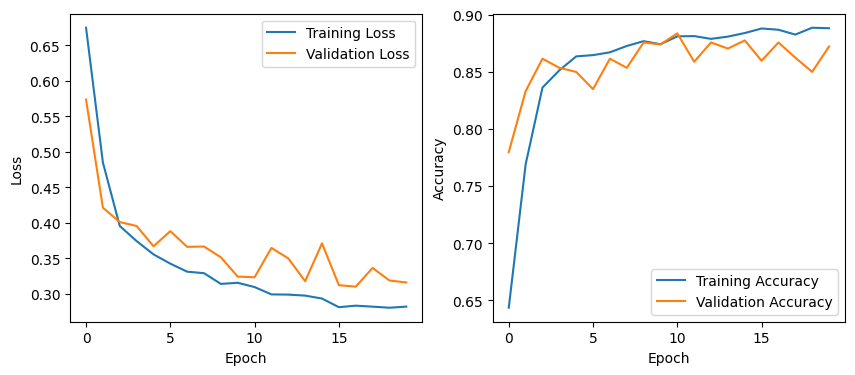

In [31]:
saved_model_path = 'best_custom_model.h5'
evaluate_model(saved_model_path, validation_generator)
plot_training_history(history)


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report


In [33]:
saved_model_path = 'best_custom_model.h5'
model = tf.keras.models.load_model(saved_model_path)


In [34]:
validation_generator.reset()  # Reset the generator to the beginning
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)


36/36 [==============================] - 59s 2s/step


In [35]:
# Assuming you have a binary classification problem
y_pred_classes = np.argmax(y_pred, axis=1)


In [36]:
confusion = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(confusion)


Confusion Matrix:
[[264  33   2   1]
 [  4 222   0   0]
 [  0   0 282  18]
 [  5   0  71 224]]


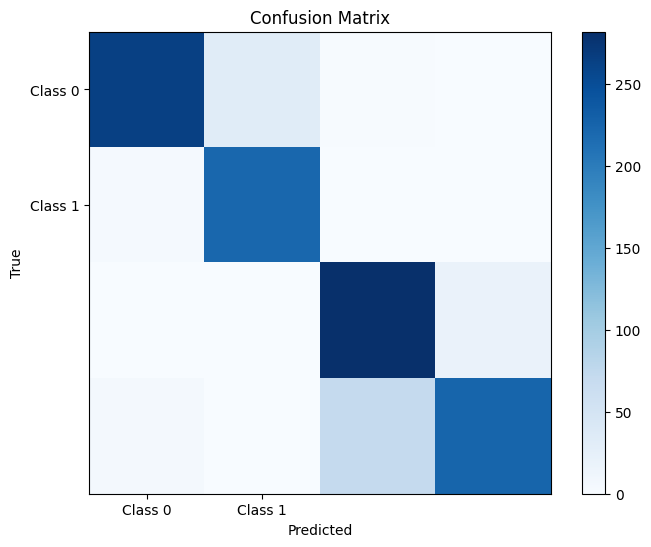

In [37]:
# You can plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(confusion, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(2), ['Class 0', 'Class 1'])  # Replace with your class labels
plt.yticks(np.arange(2), ['Class 0', 'Class 1'])  # Replace with your class labels
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [38]:
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.88      0.92       300
           2       0.87      0.98      0.92       226
           3       0.79      0.94      0.86       300
           4       0.92      0.75      0.83       300

    accuracy                           0.88      1126
   macro avg       0.89      0.89      0.88      1126
weighted avg       0.89      0.88      0.88      1126

